# postISR on WFS corner sensors using bscDbType: image


In [1]:
# to reload WepController after some code editing,
# need to run the code below - 
# it tells python to remove the name binding. 
# Python searches sys.modules to see whether 
# the modules had already been imported,
# and if they had, they are not reloaded 
import sys
# del sys.modules['lsst.ts.wep.WepController']
# del sys.modules['lsst.ts.wep.ctrlIntf.WEPCalculationFactory']

from lsst.ts.wep.WepController import WepController
from lsst.ts.wep.ctrlIntf.WEPCalculationFactory import WEPCalculationFactory

# mostly from runCloseLoopPostISR.py 
from lsst.ts.wep.Utility import CamType, FilterType, getModulePath, mapFilterRefToG, DefocalType

Just to be sure, remove the old database, which would still be there if we didn't finish the loop

In [4]:
import os 
path_to_ts_wep = '/epyc/users/suberlak/Commissioning/aos/ts_wep/'
bscDataDir = os.path.join(path_to_ts_wep, 'tests/testData')
dbFile = 'bsc.db3'
if dbFile  in os.listdir(bscDataDir):
    os.remove(os.path.join(bscDataDir,dbFile))
    print('Removed old %s file'%dbFile)

Removed old bsc.db3 file


In [5]:
import sys
sys.path.append('../analysis_tools/')
import analysisTools as at

In [6]:
topDir = '/epyc/users/suberlak/Commissioning/aos/ts_phosim/notebooks/analysis_scripts/results_gaia/'
closed_loop_input_dir = os.path.join(topDir,'dr2_med_full_2020_24_wideWFS/input/')
raInDeg, decInDeg = at.getRaDecFromGaiaField('med')

For this field, the raInDeg=233.017, decInDeg=-4.447


Need to manually change the setting in `policy/default.yaml` , because there is no way to force `ts_wep` to actually instantiate the `wep_calculator` while using a different settings file ... 

In [7]:
# what bscDbType do we want to use ? 
bscDbType = 'image'

from lsst.ts.wep.ParamReader import ParamReader
settingFilePath = os.path.join(path_to_ts_wep, 'policy/default.yaml')
settingFile = ParamReader(filePath=settingFilePath)
print('Before change: ', settingFile.getSetting("bscDbType"))


# In the following we update the setting for bscDbType saving the change in the default.yaml file 
settingFile.updateSetting("bscDbType", bscDbType)
settingFile.saveSetting(filePath=settingFilePath)

# check that the change indeed took place 
settingFilePath = os.path.join(path_to_ts_wep, 'policy/default.yaml')
settingFile = ParamReader(filePath=settingFilePath)
print('After change: ', settingFile.getSetting("bscDbType"))




Before change:  file
After change:  image


In [ ]:
print('Using %s '%closed_loop_input_dir )

# these are basically parts of WEPCalculationFactory.py  calculateWavefrontErrors()
# skipping the ingest and ISR 
wep_calc = WEPCalculationFactory.getCalculator(CamType.LsstCam, closed_loop_input_dir)
wep_calc.wepCntlr.setPostIsrCcdInputs(os.path.join(closed_loop_input_dir, 'rerun/run1'))
rotAngInDeg = 0.0
wep_calc.setBoresight(raInDeg, decInDeg)
wep_calc.setRotAng(rotAngInDeg)
        
obsIdList = [9006002]
neighborStarMap = wep_calc._getTargetStar(obsIdList, defocalState=DefocalType.Intra)


Using /epyc/users/suberlak/Commissioning/aos/ts_phosim/notebooks/analysis_scripts/results_gaia/dr2_med_full_2020_24_wideWFS/input/ 
{'visit': 9006002, 'filter': 'g', 'raftName': 'R00', 'detectorName': 'S22'}


In [17]:
import numpy as np
np.save('neighborStarMap.npz', neighborStarMap,)

In [18]:
###
# below are parts of _calcWfErr() that we are testing : 
###
sensorNameList = list(neighborStarMap)
# detector_list = sensorNameList
isrImgMap = wep_calc.wepCntlr.getPostIsrImgMapOnCornerWfs(sensorNameList, obsIdList[0])

doDeblending = wep_calc.settingFile.getSetting("doDeblending")

postageImgDir = os.path.join(closed_loop_input_dir, 'postage')
if not os.path.exists(postageImgDir):
    os.makedirs(postageImgDir)



R:0,0 S:2,2,A is intra-focal
R:0,4 S:2,0,A is intra-focal
R:4,0 S:0,2,A is intra-focal
R:4,4 S:0,0,A is intra-focal
R:0,4 S:2,0,B is extra-focal
R:4,0 S:0,2,B is extra-focal


In [19]:
donutMap = wep_calc.wepCntlr.getDonutMap(neighborStarMap, isrImgMap, FilterType.REF,
                                         doDeblending=doDeblending, 
                                         postageImg=True,postageImgDir=postageImgDir)


 Calculating the donut map 
Saving postage stamp images in /epyc/users/suberlak/Commissioning/aos/ts_phosim/notebooks/analysis_scripts/results_gaia/dr2_med_full_2020_24_wideWFS/input/postage

Saving postage stamp as intra_singleSciImg_sensor-R00_S22_C0_star-0_id-12_posX-824_posY-813.txt
Saving postage stamp image as intra_imgDeblend_full_sensor-R00_S22_C0_star-0_id-12_posX-824_posY-813.txt
Saving postage stamp image as intra_imgDeblend_resized_sensor-R00_S22_C0_star-0_id-12_posX-824_posY-813.txt

Saving postage stamp as intra_singleSciImg_sensor-R00_S22_C0_star-1_id-13_posX-740_posY-1402.txt
Saving postage stamp image as intra_imgDeblend_full_sensor-R00_S22_C0_star-1_id-13_posX-740_posY-1402.txt
Saving postage stamp image as intra_imgDeblend_resized_sensor-R00_S22_C0_star-1_id-13_posX-740_posY-1402.txt

Saving postage stamp as intra_singleSciImg_sensor-R00_S22_C0_star-2_id-14_posX-613_posY-3765.txt
Saving postage stamp image as intra_imgDeblend_full_sensor-R00_S22_C0_star-2_id-14_posX

Plot these postage stamps:

Using postage images from /epyc/users/suberlak/Commissioning/aos/ts_phosim/notebooks/analysis_scripts/results_gaia/dr2_med_full_2020_24_wideWFS/input/postage
Searching in /epyc/users/suberlak/Commissioning/aos/ts_phosim/notebooks/analysis_scripts/results_gaia/dr2_med_full_2020_24_wideWFS/input/postage directory

Available postage stamp images for sensor R00_S22: 

Looking for files that start with "intra_singleSciImg" and contain "R00_S22"...

Found 3 singleSciImg postage stamp images 
['intra_singleSciImg_sensor-R00_S22_C0_star-0_id-12_posX-824_posY-813.txt', 'intra_singleSciImg_sensor-R00_S22_C0_star-1_id-13_posX-740_posY-1402.txt', 'intra_singleSciImg_sensor-R00_S22_C0_star-2_id-14_posX-613_posY-3765.txt']

Looking for files that start with "intra_imgDeblend_full" and contain "R00_S22"...

Found 3 imgDeblend_full postage stamp images 
['intra_imgDeblend_full_sensor-R00_S22_C0_star-0_id-12_posX-824_posY-813.txt', 'intra_imgDeblend_full_sensor-R00_S22_C0_star-1_id-13_posX-740_posY-140

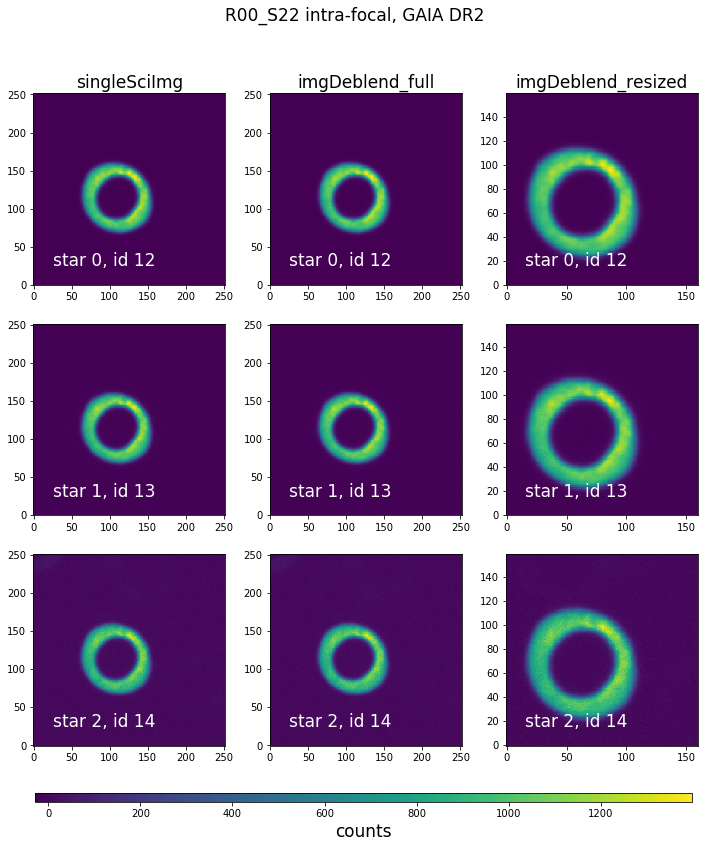

In [25]:
%matplotlib inline
import imp
imp.reload(at)
postage_dir= os.path.join(closed_loop_input_dir, 'postage')
at.plotPostageStamps(postage_dir, sensor='R00_S22', focalType='intra', Nstars=None,
                     testLabel='gaia')

Show the postISR image

In [22]:
data_dir = closed_loop_input_dir[:-len('/input')]
print(data_dir)
image = at.readPostISRImage(data_dir, focalType = 'intra', raft = 'R00', detector = 'S22',
                           rerun='run1')


/epyc/users/suberlak/Commissioning/aos/ts_phosim/notebooks/analysis_scripts/results_gaia/dr2_med_full_2020_24_wideWFS/
data_id is
{'visit': 9006002, 'filter': 'g', 'raftName': 'R00', 'detectorName': 'S22', 'detector': 197}
Reading postISR images from the following repo_dir:
/epyc/users/suberlak/Commissioning/aos/ts_phosim/notebooks/analysis_scripts/results_gaia/dr2_med_full_2020_24_wideWFS/input/rerun/run1
Done



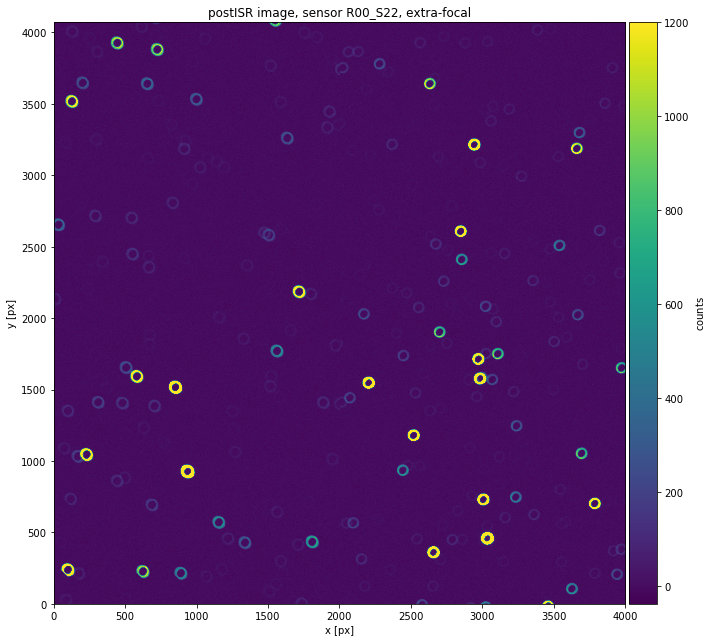

In [49]:
at.plotImage(image,ax=None, log=False, sensor='R00_S22', focalType='extra',
          postage=None,postFlag=False, centroid=False, 
          starMarker='redCross',starMarkerArgs=None,
          centMarkerArgs = None,centMarker='redCross', plotArgs = { 'vmax':1200})

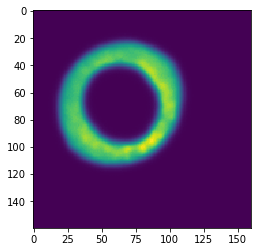

In [42]:
plt.imshow(donutMap['R:0,0 S:2,2,A'][0].getIntraImg())

In [43]:
postageImgDir

'/epyc/users/suberlak/Commissioning/aos/ts_phosim/notebooks/analysis_scripts/results_gaia/dr2_med_full_2020_24_wideWFS/input/postage'

In [44]:
# now pass the donutMap to WepController to calculate wavefront error :
donutMap2 = wep_calc.wepCntlr.calcWfErr(donutMap,postageImgDir)




 Calculating the wavefront error based on the donut map


KeyError: 'R:0,0 S:2,2,B'

This fails because the code expects to find both intra and extra-focal donuts,  i.e.  `R:0,0 S:2,2,A`. and `R:0,0 S:2,2,B`... But it doesn't. So with `bscDbType : image`, not enough donuts are found at `_getTargetStar()` stage. 

## NEXT : 

In [ ]:
#
# TO DO : final steps 
#
wfs_zer_output = 'wfs.gaia.corner.txt'

listOfWfErr = wep_calc._populateListOfSensorWavefrontData(donutMap2)

zerDict = {}
for wfErrObj in listOfWfErr:
    zerDict[wfErrObj.getSensorId()] = wfErrObj.getAnnularZernikePoly()

sensorKeys = list(zerDict.keys())
sensorKeys.sort()

zerList = []
for sensorKey in sensorKeys:
    zerList.append(zerDict[sensorKey])
zerArray = np.array(zerList)

wfs_output_path = os.path.join(closed_loop_input_dir, wfs_zer_output)
np.savetxt(wfs_output_path, zerArray, header='The following are ZK in um from z4 to z22:')
print('WFS Zernike results saved as %s'%(wfs_output_path))

Show the Zernike errors : 

In [1]:
data_dir = closed_loop_input_dir[:-6]
opdZkFilePath = os.path.join(data_dir,  'iter0/img/opd.zer.gaia')
opdData = np.loadtxt(opdZkFilePath)


# new results, bscDbType: image, new ISR 
wfsZkFilePath1 = os.path.join(closed_loop_input_dir, 'wfs.gaia.corner.txt')
wfsData1 = np.loadtxt(wfsZkFilePath1)

### Plot all the corner wavefront sensors simulated with GAIA DR2 catalog: 

In [47]:
images = {}
for sensor in ['R00_S22', 'R40_S02', 'R44_S00', 'R04_S20']:
    raft = sensor[:3]
    detector = sensor[-3:]
    print(raft,detector)
    images[sensor] = at.readPostISRImage(data_dir, focalType = 'intra', 
                                         raft = raft, detector = detector,)


R00 S22
data_id is
{'visit': 9006002, 'filter': 'g', 'raftName': 'R00', 'detectorName': 'S22', 'detector': 197}
Reading postISR images from the following repo_dir:
/epyc/users/suberlak/Commissioning/aos/ts_phosim/notebooks/analysis_scripts/results_gaia/dr2_med_full_2020_24_wideWFS/input/rerun/run1
Done

R40 S02
data_id is
{'visit': 9006002, 'filter': 'g', 'raftName': 'R40', 'detectorName': 'S02', 'detector': 209}
Reading postISR images from the following repo_dir:
/epyc/users/suberlak/Commissioning/aos/ts_phosim/notebooks/analysis_scripts/results_gaia/dr2_med_full_2020_24_wideWFS/input/rerun/run1
Done

R44 S00
data_id is
{'visit': 9006002, 'filter': 'g', 'raftName': 'R44', 'detectorName': 'S00', 'detector': 216}
Reading postISR images from the following repo_dir:
/epyc/users/suberlak/Commissioning/aos/ts_phosim/notebooks/analysis_scripts/results_gaia/dr2_med_full_2020_24_wideWFS/input/rerun/run1
Done

R04 S20
data_id is
{'visit': 9006002, 'filter': 'g', 'raftName': 'R04', 'detectorName

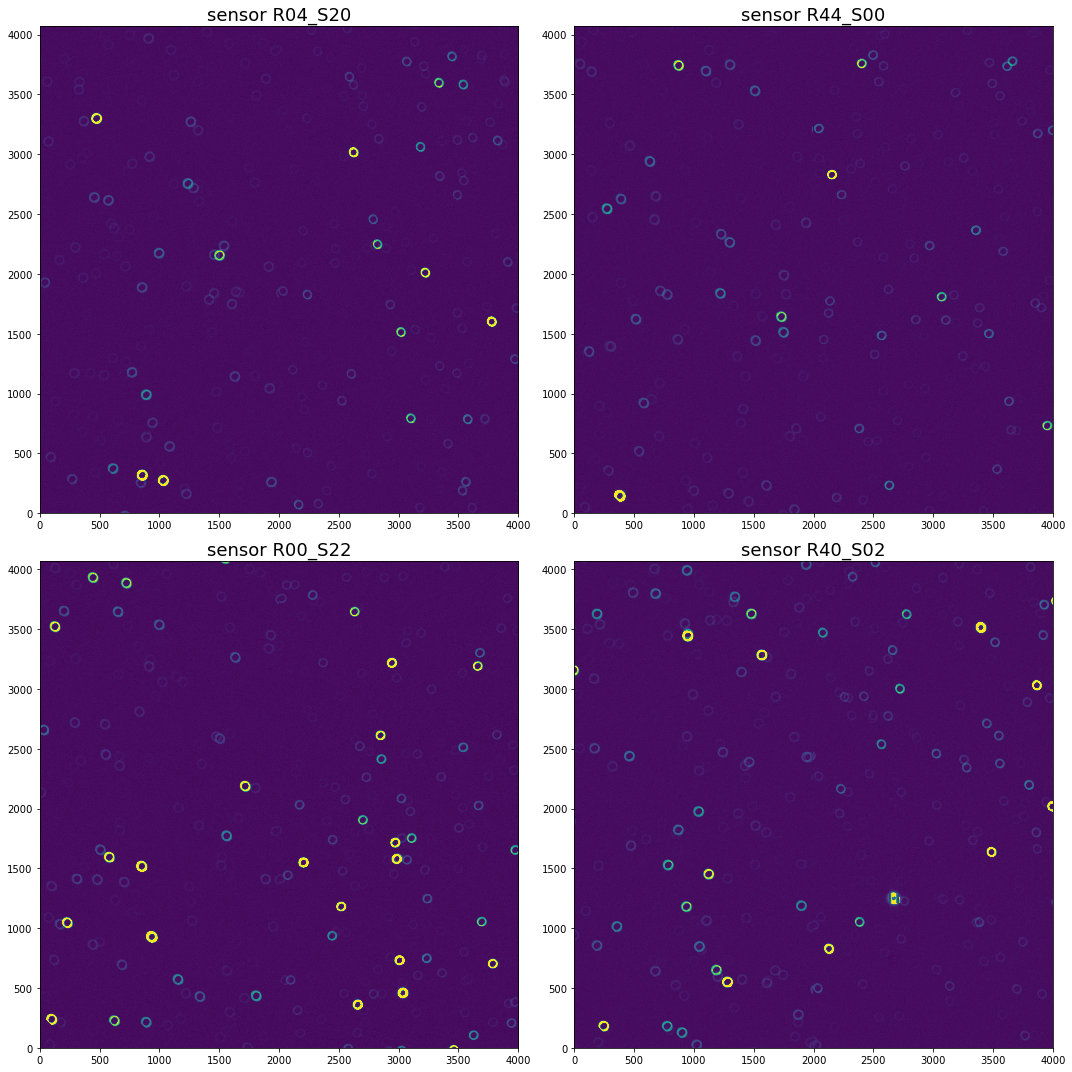

In [48]:
%matplotlib inline

fig, axs = plt.subplots(2,2,figsize=(15,15))
ax = np.ravel(axs)

i = 0 
for sensor in ['R04_S20', 'R44_S00', 'R00_S22', 'R40_S02']:
    img = ax[i].imshow(images[sensor].T, origin='lower', vmax=1200)
    ax[i].set_title('sensor %s'%sensor, fontsize=18)
    i += 1 

plt.tight_layout()

plt.savefig('GAIA_DR2_med_corner_sensors.png', bbox_inches='tight')